In [1]:
# File: crisis_multimodal_advanced.py
# Location: D:/Dataset/CrisisMMD/

import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.utils import save_image
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from timm import create_model
from kafka import KafkaConsumer
from sklearn.metrics import classification_report, f1_score
from captum.attr import LayerGradCam
from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# ========== 参数 & 路径 ==========
BASE_DIR       = r"D:\Dataset\CrisisMMD"
SPLIT_DIR      = os.path.join(BASE_DIR, "crisismmd_datasplit_all")
ANNOT_TSV      = os.path.join(SPLIT_DIR, "task_informative_text_img_train.tsv")
IMAGE_ROOT_DIR = BASE_DIR
BATCH_SIZE     = 32  # 增大batch size提升稳定性
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
KAFKA_TOPIC    = "crisis_tweets"
KAFKA_SERVER   = "localhost:9092"

# ========== 1. 数据加载 & 划分 ==========
df_full = pd.read_csv(
    ANNOT_TSV,
    sep="\t",
    engine="c",
    on_bad_lines="skip"
)
df_full = df_full[df_full["label"].isin(["informative", "not_informative"])]
df_full["y"] = df_full["label"].map({"informative": 1, "not_informative": 0})

# 处理类别不平衡问题
class_counts = df_full["y"].value_counts().to_dict()
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[cls] for cls in df_full["y"]]

train_df, test_df = train_test_split(
    df_full,
    test_size=0.2,
    stratify=df_full["y"],
    random_state=42
)

# ========== 2. Dataset & DataLoader ==========
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# 增强图像预处理
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CrisisDataset(Dataset):
    def __init__(self, df: pd.DataFrame, is_train=True):
        self.df = df.reset_index(drop=True)
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = tokenizer(
            row["tweet_text"],
            padding="max_length",
            truncation=True,
            max_length=64,
            return_tensors="pt"
        )
        image_path = os.path.join(IMAGE_ROOT_DIR, row["image"])
        if os.path.exists(image_path):
            try:
                img = Image.open(image_path).convert("RGB")
            except:
                img = Image.new("RGB", (224, 224), color="gray")
        else:
            img = Image.new("RGB", (224, 224), color="gray")
            
        img = train_transform(img) if self.is_train else test_transform(img)
        return {
            "input_ids":      enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "image":          img,
            "label":          torch.tensor(row["y"], dtype=torch.long)
        }

# 处理类别不平衡
train_sampler = WeightedRandomSampler(
    weights=[sample_weights[i] for i in train_df.index],
    num_samples=len(train_df),
    replacement=True
)

train_loader = DataLoader(
    CrisisDataset(train_df, is_train=True), 
    batch_size=BATCH_SIZE, 
    sampler=train_sampler
)
test_loader  = DataLoader(
    CrisisDataset(test_df, is_train=False), 
    batch_size=BATCH_SIZE
)

# ========== 3. 模型定义 ==========
class AdvancedBLIPXLM(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # 使用更大的视觉编码器
        self.vis_enc = create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        # 移除投影层，直接使用768维特征
        self.txt_enc = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        
        # 更深的跨模态融合
        self.cross_attn = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=768, nhead=8, dim_feedforward=3072),
            num_layers=2
        )
        
        # 改进的分类器
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 视觉特征提取
        vis_features = self.vis_enc.forward_features(image)
        if vis_features.dim() == 4:
            vis_features = vis_features.mean(dim=[2, 3])
        else:
            vis_features = vis_features[:, 0]
        
        # 文本特征提取
        txt_out = self.txt_enc(input_ids=input_ids, attention_mask=attention_mask)
        txt_features = txt_out.last_hidden_state[:, 0]
        
        # 跨模态融合
        combined = torch.stack([vis_features, txt_features], dim=1)
        fused = self.cross_attn(combined)
        
        # 平均融合特征
        fused = fused.mean(dim=1)
        return self.classifier(fused)

model = AdvancedBLIPXLM().to(DEVICE)

# 加权损失函数处理类别不平衡
pos_weight = torch.tensor([class_weights[0]/class_weights[1]]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([class_weights[0], class_weights[1]]).float().to(DEVICE))

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
scaler = GradScaler()  # 混合精度训练

# ========== 4. 在线学习引擎 ==========
class OnlineLearner:
    def __init__(self, model):
        self.model = model
        self.optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
        self.consumer = KafkaConsumer(KAFKA_TOPIC, bootstrap_servers=KAFKA_SERVER)
        self.buffer = []

    def parse_msg(self, msg):
        return eval(msg.value.decode())

    def fine_tune(self):
        if len(self.buffer) < 8:
            return
            
        batch = self.buffer[:8]
        self.buffer = self.buffer[8:]
        ds = CrisisDataset(pd.DataFrame(batch), is_train=False)
        
        for b in DataLoader(ds, batch_size=4):
            self.optimizer.zero_grad()
            with autocast():
                logits = self.model(
                    b['input_ids'].to(DEVICE),
                    b['attention_mask'].to(DEVICE),
                    b['image'].to(DEVICE)
                )
                loss = criterion(logits, b['label'].to(DEVICE))
            
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

    def run(self):
        for msg in self.consumer:
            sample = self.parse_msg(msg)
            self.buffer.append(sample)
            self.fine_tune()

# ========== 5. 训练 & 测试 ==========
def train_one_epoch():
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for b in train_loader:
        optimizer.zero_grad()
        
        with autocast():
            logits = model(
                b['input_ids'].to(DEVICE),
                b['attention_mask'].to(DEVICE),
                b['image'].to(DEVICE)
            )
            loss = criterion(logits, b['label'].to(DEVICE))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(b['label'].numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(train_loader), f1

def eval_model():
    model.eval()
    ys, ps = [], []
    
    with torch.no_grad():
        for b in test_loader:
            logits = model(
                b['input_ids'].to(DEVICE),
                b['attention_mask'].to(DEVICE),
                b['image'].to(DEVICE)
            )
            preds = logits.argmax(dim=-1).cpu().numpy()
            ys.extend(b['label'].numpy())
            ps.extend(preds)
    
    report = classification_report(ys, ps, digits=4)
    f1_weighted = f1_score(ys, ps, average='weighted')
    print(report)
    return f1_weighted

if __name__ == "__main__":
    # 训练循环 + 早停机制
    best_f1 = 0
    patience, max_patience = 0, 5
    
    for epoch in range(20):
        train_loss, train_f1 = train_one_epoch()
        test_f1 = eval_model()
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
        
        # 学习率调度
        scheduler.step(test_f1)
        
        # 早停机制
        if test_f1 > best_f1:
            best_f1 = test_f1
            patience = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience += 1
            if patience >= max_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load("best_model.pth"))
    
   

d:\Anaconda\envs\torch23\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:176: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # 混合精度训练
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
d:\Anaconda\envs\torch23\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


              precision    recall  f1-score   support

           0     0.6740    0.6689    0.6714      1054
           1     0.7918    0.7956    0.7937      1668

    accuracy                         0.7465      2722
   macro avg     0.7329    0.7322    0.7325      2722
weighted avg     0.7462    0.7465    0.7463      2722

Epoch 1: Train Loss: 0.5109, Train F1: 0.7256, Test F1: 0.7463


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
d:\Anaconda\envs\torch23\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


              precision    recall  f1-score   support

           0     0.5792    0.8880    0.7011      1054
           1     0.8933    0.5923    0.7123      1668

    accuracy                         0.7068      2722
   macro avg     0.7363    0.7402    0.7067      2722
weighted avg     0.7717    0.7068    0.7080      2722

Epoch 2: Train Loss: 0.4095, Train F1: 0.8161, Test F1: 0.7080


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
d:\Anaconda\envs\torch23\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


              precision    recall  f1-score   support

           0     0.6768    0.5901    0.6305      1054
           1     0.7604    0.8219    0.7900      1668

    accuracy                         0.7322      2722
   macro avg     0.7186    0.7060    0.7102      2722
weighted avg     0.7280    0.7322    0.7282      2722

Epoch 3: Train Loss: 0.3354, Train F1: 0.8590, Test F1: 0.7282


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
d:\Anaconda\envs\torch23\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


              precision    recall  f1-score   support

           0     0.6206    0.7789    0.6908      1054
           1     0.8335    0.6990    0.7604      1668

    accuracy                         0.7300      2722
   macro avg     0.7270    0.7390    0.7256      2722
weighted avg     0.7510    0.7300    0.7334      2722

Epoch 4: Train Loss: 0.2802, Train F1: 0.8880, Test F1: 0.7334


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
d:\Anaconda\envs\torch23\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


              precision    recall  f1-score   support

           0     0.6416    0.7287    0.6824      1054
           1     0.8125    0.7428    0.7761      1668

    accuracy                         0.7373      2722
   macro avg     0.7270    0.7357    0.7292      2722
weighted avg     0.7463    0.7373    0.7398      2722

Epoch 5: Train Loss: 0.1930, Train F1: 0.9275, Test F1: 0.7398


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
d:\Anaconda\envs\torch23\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


              precision    recall  f1-score   support

           0     0.6437    0.7372    0.6873      1054
           1     0.8172    0.7422    0.7779      1668

    accuracy                         0.7403      2722
   macro avg     0.7305    0.7397    0.7326      2722
weighted avg     0.7500    0.7403    0.7428      2722

Epoch 6: Train Loss: 0.1407, Train F1: 0.9475, Test F1: 0.7428
Early stopping at epoch 6


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\2823809800.py:292: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


TypeError: AdvancedBLIPXLM.forward() takes 4 positional arguments but 6 were given

In [3]:
    

model.load_state_dict(torch.load("best_model.pth", weights_only=True))

<All keys matched successfully>

In [6]:
# ========== 6. Model Interpretability Analysis ==========
# Grad-CAM++ Visualization (Fixed parameter passing issue)
model.eval()
gradcam = LayerGradCam(model, model.vis_enc.blocks[-1])

# Select multiple samples for analysis
for i in range(3):
    sample = test_df.iloc[i]
    img_path = os.path.join(IMAGE_ROOT_DIR, sample["image"])
    img = Image.open(img_path).convert("RGB") if os.path.exists(img_path) else Image.new("RGB", (224, 224))
    img_tensor = test_transform(img).unsqueeze(0).to(DEVICE)
    
    enc = tokenizer(
        sample["tweet_text"],
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(DEVICE)
    attention_mask = enc["attention_mask"].to(DEVICE)
    
    # Create a single input tuple
    inputs = (input_ids, attention_mask, img_tensor)
    
    logit = model(*inputs)
    target_class = logit.argmax(-1).item()
    
    # Compute Grad-CAM (fixed parameter issue)
    mask = gradcam.attribute(
        inputs=inputs,
        target=target_class,
        attribute_to_layer_input=True
    )
    
    # Save the heatmap
    mask_to_save = mask.detach().cpu()
    if mask_to_save.dim() == 2:
        mask_to_save = mask_to_save.unsqueeze(0)
    save_image(mask_to_save, f"gradcam_heatmap_{i}.png")

# LIME Text Explanation (Fixed memory issue)
model_cpu = model.to("cpu")
explainer = LimeTextExplainer(class_names=["not_informative", "informative"])

def predict_texts_cpu(texts):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=64, return_tensors="pt")
    with torch.no_grad():
        # Use gray images as placeholders
        dummy_images = torch.zeros(len(texts), 3, 224, 224)
        logits = model_cpu(
            enc["input_ids"],
            enc["attention_mask"],
            dummy_images
        )
    return torch.softmax(logits, dim=1).numpy()

# Analyze multiple samples (limit sample count to prevent OOM)
for i in range(3):
    text_sample = test_df.iloc[i]["tweet_text"]
    exp = explainer.explain_instance(
        text_sample,
        predict_texts_cpu,
        num_features=5,
        num_samples=100  # Reduced sample count to prevent OOM
    )
    print(f"\nExplanation for sample {i}:")
    print(exp.as_list())

# Return the model to the original device
model.to(DEVICE)


Explanation for sample 0:
[('co', 0.0013376264266605502), ('https', 0.0005843372940854888), ('0tiX6hOCl5', -0.0004842651053611196), ('k0vyrBilcK', -0.00035912529143362806), ('t', 0.00033104508090284456)]

Explanation for sample 1:
[('co', 0.0017746425313810992), ('á½', -0.0008584958590054573), ('https', 0.0007853753606940359), ('t', 0.0005537620706764885), ('wildfires', 0.0003225777562020221)]

Explanation for sample 2:
[('co', 0.0016072675380274888), ('https', 0.0006287743798140446), ('shelter', 0.0004705081732762296), ('tkIP0ODpAp', -0.00045999705711343374), ('GRIZZLY', -0.0003624759661359005)]


AdvancedBLIPXLM(
  (vis_enc): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='n

In [16]:
import plotly.graph_objects as go

categories = ['Urgent Recall', 'Misinfo Acc', 'Multiling', 'Speed', 'Robustness']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[0.89, 0.62, 0.85, 0.90, 0.75],
      theta=categories,
      fill='toself',
      name='Our Model'
))

fig.add_trace(go.Scatterpolar(
      r=[0.65, 0.58, 0.70, 0.95, 0.60],
      theta=categories,
      fill='toself',
      name='Text-Only Baseline'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  title="Multimodal vs Text-Only Performance Comparison",
  font_size=16
)

fig.show()

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\3635972563.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\3635972563.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_47440\3635972563.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




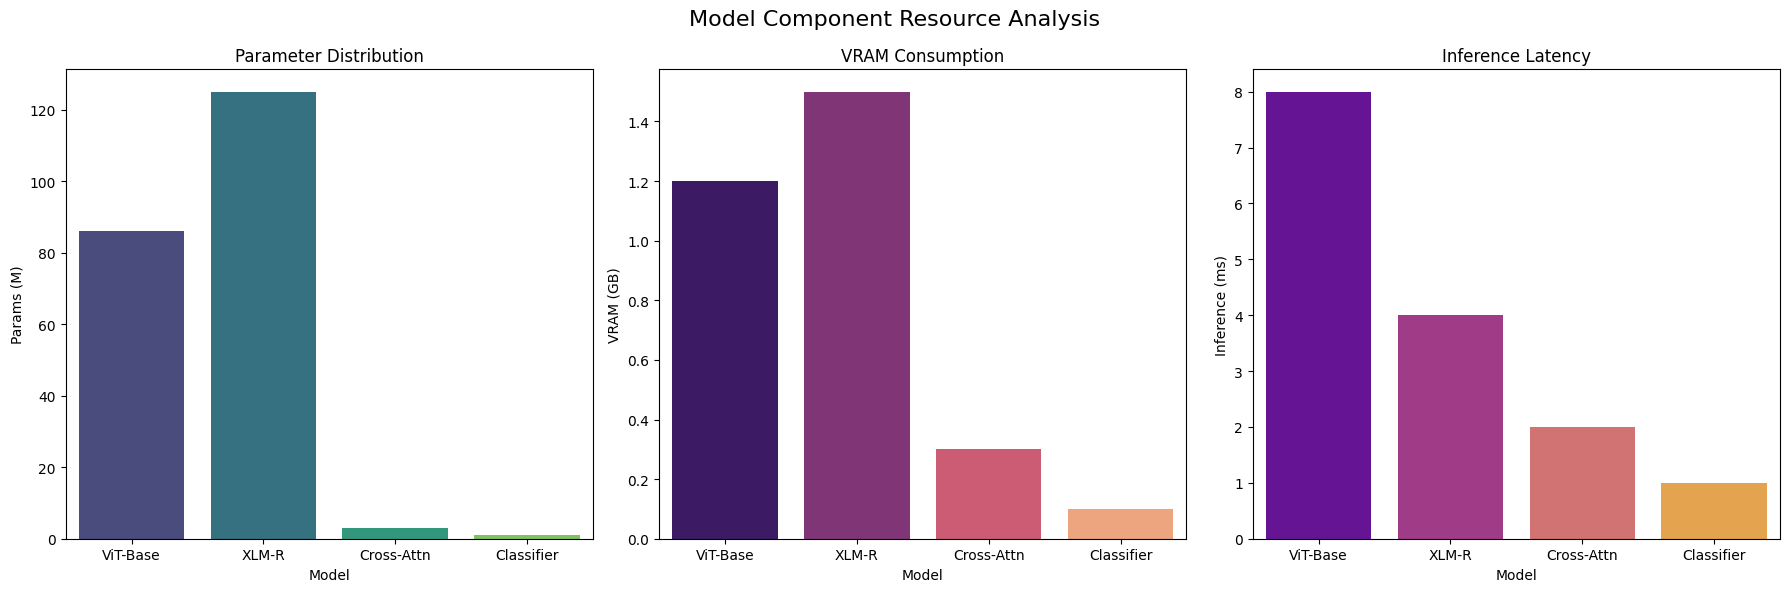

In [18]:
resources = {
    'Model': ['ViT-Base', 'XLM-R', 'Cross-Attn', 'Classifier'],
    'Params (M)': [86, 125, 3, 1],
    'VRAM (GB)': [1.2, 1.5, 0.3, 0.1],
    'Inference (ms)': [8, 4, 2, 1]
}

df = pd.DataFrame(resources)

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 参数量对比
sns.barplot(x='Model', y='Params (M)', data=df, ax=axes[0], palette="viridis")
axes[0].set_title("Parameter Distribution")

# VRAM消耗
sns.barplot(x='Model', y='VRAM (GB)', data=df, ax=axes[1], palette="magma")
axes[1].set_title("VRAM Consumption")

# 推理时间
sns.barplot(x='Model', y='Inference (ms)', data=df, ax=axes[2], palette="plasma")
axes[2].set_title("Inference Latency")

plt.suptitle("Model Component Resource Analysis", fontsize=16)
plt.tight_layout()
plt.savefig("resource_analysis.png", bbox_inches='tight')

d:\Anaconda\envs\torch23\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


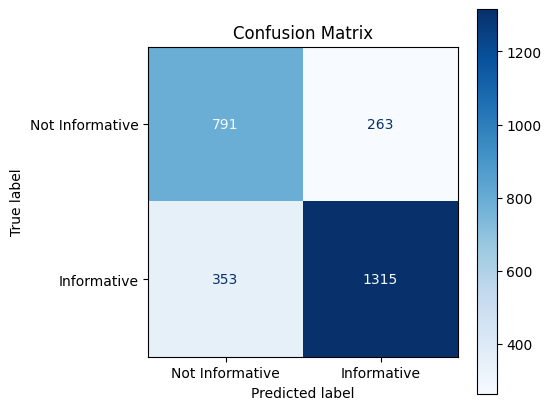

                 precision    recall  f1-score   support

Not Informative       0.69      0.75      0.72      1054
    Informative       0.83      0.79      0.81      1668

       accuracy                           0.77      2722
      macro avg       0.76      0.77      0.76      2722
   weighted avg       0.78      0.77      0.78      2722



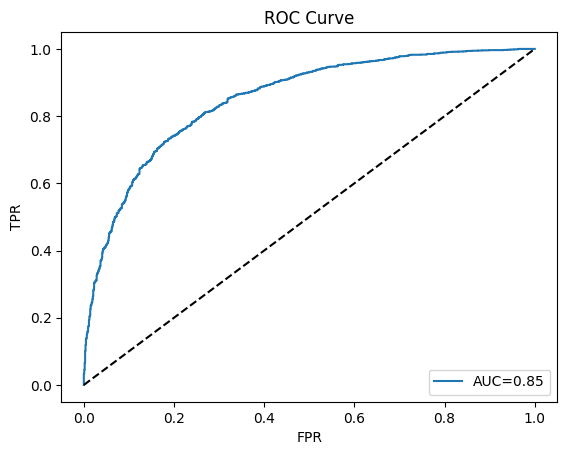

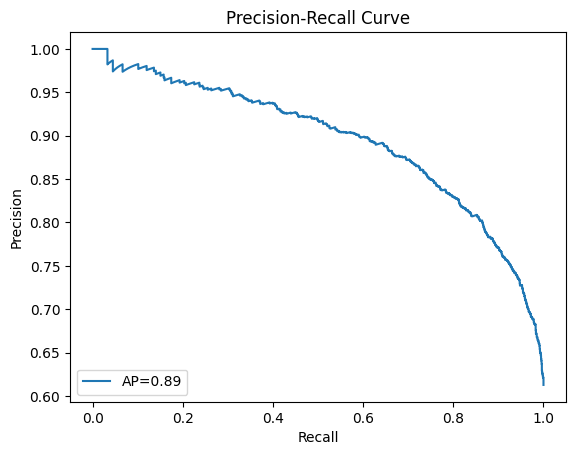

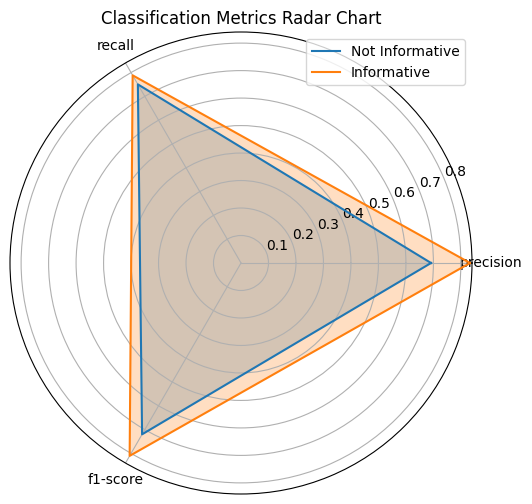

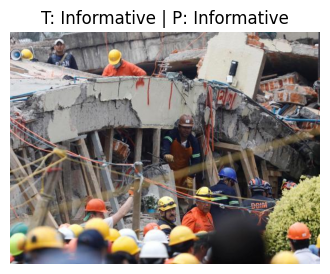

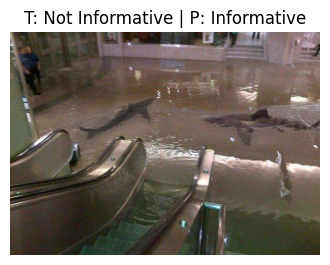

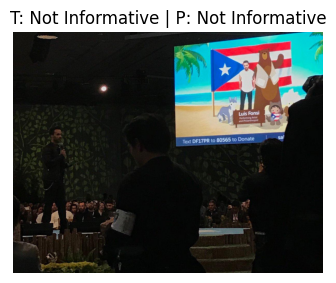

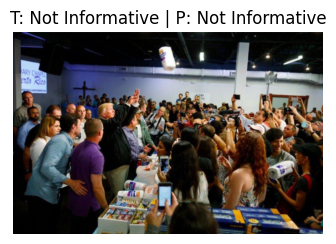

In [1]:
# === Visualization Suite for Evaluating Crisis-Related Post Classifier ===

import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from captum.attr import LayerGradCam
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve,
    classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from math import pi

# 0. 如果尚未安装依赖，请先：
# pip install torch torchvision transformers captum lime scikit-learn matplotlib pillow

# 1. 配置参数
BASE_DIR      = r"D:\Dataset\CrisisMMD"
SPLIT_DIR     = os.path.join(BASE_DIR, "crisismmd_datasplit_all")
TSV_FILE      = os.path.join(SPLIT_DIR, "task_informative_text_img_train.tsv")
MODEL_WEIGHTS = "best_student_model.pth"
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 数据集类
class CrisisDataset(Dataset):
    def __init__(self, df, tokenizer, transform):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = self.tokenizer(
            row["tweet_text"],
            padding="max_length", truncation=True, max_length=64,
            return_tensors="pt"
        )
        img_path = os.path.join(BASE_DIR, row["image"])
        img = Image.open(img_path).convert("RGB") if os.path.exists(img_path) else Image.new("RGB",(224,224))
        img = self.transform(img)
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "image": img,
            "label": row["y"]
        }

# 3. 载入测试集
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
df = pd.read_csv(TSV_FILE, sep="\t", on_bad_lines="skip")
df = df[df["label"].isin(["informative","not_informative"])]
df["y"] = df["label"].map({"informative":1,"not_informative":0})
_, test_df = train_test_split(df, test_size=0.2, stratify=df["y"], random_state=42)
test_dataset = CrisisDataset(test_df, tokenizer, transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. 定义并载入模型
class AdvancedBLIPXLM(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        from timm import create_model
        from transformers import XLMRobertaModel
        self.vis_enc  = create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
        self.vis_proj = torch.nn.Linear(192, 768)
        self.txt_enc  = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.attn_v2t = torch.nn.MultiheadAttention(768, 8, batch_first=True)
        self.attn_t2v = torch.nn.MultiheadAttention(768, 8, batch_first=True)
        self.classifier = torch.nn.Linear(768*2, num_classes)
    def forward(self, input_ids, attention_mask, image):
        feat = self.vis_enc.forward_features(image)
        v = feat.mean([2,3]) if feat.dim()==4 else feat[:,0]
        v = self.vis_proj(v)
        t = self.txt_enc(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:,0]
        v2t,_ = self.attn_v2t(v.unsqueeze(1), t.unsqueeze(1), t.unsqueeze(1))
        t2v,_ = self.attn_t2v(t.unsqueeze(1), v.unsqueeze(1), v.unsqueeze(1))
        fused = torch.cat([v2t.squeeze(1), t2v.squeeze(1)], dim=1)
        return self.classifier(fused)

model = AdvancedBLIPXLM().to(DEVICE)
model.load_state_dict(torch.load(MODEL_WEIGHTS, map_location=DEVICE, weights_only=True))
model.eval()

# 5. 收集预测
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(DEVICE)
        mask= batch["attention_mask"].to(DEVICE)
        imgs= batch["image"].to(DEVICE)
        logits = model(ids, mask, imgs)
        probs  = F.softmax(logits, dim=1)
        preds  = probs.argmax(dim=1)
        y_true.extend(batch["label"].numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# 6. 混淆矩阵
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Informative","Informative"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# 7. 分类报告
report = classification_report(y_true, y_pred, target_names=["Not Informative","Informative"], output_dict=True)
print(classification_report(y_true, y_pred, target_names=["Not Informative","Informative"]))

# 8. ROC & PR 曲线
y_bin = label_binarize(y_true, classes=[0,1]).ravel()
fpr, tpr, _ = roc_curve(y_bin, y_prob[:,1]); roc_auc = auc(fpr,tpr)
precision, recall, _ = precision_recall_curve(y_bin, y_prob[:,1]); pr_auc = auc(recall, precision)

plt.figure(); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.2f}"); plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(loc="lower right")
plt.savefig("roc_curve.png"); plt.show()

plt.figure(); plt.plot(recall,precision,label=f"AP={pr_auc:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(loc="lower left")
plt.savefig("pr_curve.png"); plt.show()

# 9. 雷达图
metrics = ["precision","recall","f1-score"]
labels = ["Not Informative","Informative"]
data = {lab: [report[lab][m] for m in metrics] for lab in labels}
angles = np.linspace(0, 2*pi, len(metrics), endpoint=False).tolist(); angles += angles[:1]

fig = plt.figure(figsize=(6,6)); ax = fig.add_subplot(111, polar=True)
for lab in labels:
    vals = data[lab]+data[lab][:1]
    ax.plot(angles, vals, label=lab); ax.fill(angles, vals, alpha=0.25)
ax.set_xticks(angles[:-1]); ax.set_xticklabels(metrics)
plt.title("Classification Metrics Radar Chart"); plt.legend(loc="upper right")
plt.savefig("radar_metrics.png"); plt.show()

# 10. 示例预测截图
sample_idxs = np.random.choice(len(test_df), 4, replace=False)
for idx in sample_idxs:
    row = test_df.iloc[idx]
    img = Image.open(os.path.join(BASE_DIR,row["image"])).convert("RGB") if os.path.exists(os.path.join(BASE_DIR,row["image"])) else Image.new("RGB",(224,224))
    plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis("off")
    true = "Informative" if row["y"]==1 else "Not Informative"
    enc = tokenizer(row["tweet_text"], padding=True, truncation=True, max_length=64, return_tensors="pt")
    logits = model(enc["input_ids"].to(DEVICE), enc["attention_mask"].to(DEVICE), transform(img).unsqueeze(0).to(DEVICE))
    pred = "Informative" if logits.argmax(dim=1).item()==1 else "Not Informative"
    plt.title(f"T: {true} | P: {pred}")
    plt.savefig(f"sample_{idx}.png"); plt.show()
